# The redshift evolution of the BBH merger rate: "a weighty matter"

## Figure 2:  the 2D histograms of Mbh and tdely at low and high metallicity


## Imports and definitions:

In [1]:
######################################
## Imports
import numpy as np
import h5py as h5
from astropy.table import Table

import matplotlib.pyplot as plt
import seaborn as sns

# Extra functions
import HelperFunctions as func

######################################
## locations
save_loc    =  '../plots/'
data_dir    = '../output/'

# This will be put in front of the name for every figure we safe 
sim_save_str = 'N1e7_'

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


######################################
## Widescreen jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Read your data

the function `read_data` is part of `HelperFunctions.py` and reads the hdf5 file containing the BBH population data and merger rates. This is expensive memory-wise
Hence the columns specifically needed for this  Figure are loaded right below that

The Bool "DCO_mask" filters for BBHs:  
1. with an inspiral time that is less than the age of the Universe
2. excludes systems that experienced a CE from a HG donor (i.e. the flag `Optimistic_CE == False`)
3. excludes systems that experienced RLOF immediately following a CE (i.e. the flag `Immediate_RLOF>CE == False`)

In other words, we treat 2. and 3. as stellar mergers and exclude them from the rest of our analysis

Lastly, we select merging BBHs using the `DCO_mask`, and aditionally exclude systems that evolve Chemically homogeneous. 
We then further divide the data into low and high metallicity using an additional bool.


In [2]:
####################################################
## Location of your data
File_location = data_dir+'COMPAS_Output_wWeights.h5'
print(File_location)

# Rate selects wich mergers you are interested in, using a specific SFRD
rate_key      = 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned'

####################################################
'''
The following function will read more information (generally useful for all plots in paper)
Warning, this is heavy on memory usage 
Bare essential data will be read below
'''
# DCO, DCO_mask, redshifts, Average_SF_mass_needed, intrinsic_rate_density, intrinsic_rate_density_z0, = func.read_data(loc = File_location, rate_key = rate_key)
# DCO.info()


################################################
## Essential data for this plot
## Open hdf5 file and read relevant columns
File        = h5.File(File_location ,'r')

DCO = Table()
DCO['SEED']                  = File['DoubleCompactObjects']['SEED'][()] 
DCO['Metallicity@ZAMS(1)']   = File['DoubleCompactObjects']['Metallicity@ZAMS(1)'][()] 
DCO['CE_Event_Count']        = File['DoubleCompactObjects']['CE_Event_Count'][()] 
DCO['tDelay']                = File['DoubleCompactObjects']['Coalescence_Time'][()] + File['DoubleCompactObjects']['Time'][()]#Myr
DCO['M_moreMassive']         = np.maximum(File['DoubleCompactObjects']['Mass(1)'][()], File['DoubleCompactObjects']['Mass(2)'][()])
DCO['mixture_weight']        = File['DoubleCompactObjects']['mixture_weight'][()]

SYS_DCO_seeds_bool           = np.in1d(File['SystemParameters']['SEED'][()], DCO['SEED']) #Bool to point SYS to DCO
DCO['Stellar_Type@ZAMS(1)']  = File['SystemParameters']['Stellar_Type@ZAMS(1)'][SYS_DCO_seeds_bool]

DCO_mask                     = File[rate_key]['DCOmask'][()] # Mask from DCO to merging BBH 

File.close()

################################################
# Bools to select merging BBHs w.o. CHE only
nonCHE_bool         = DCO['Stellar_Type@ZAMS(1)'] != 16
rate_nonCHE_bool    = DCO['Stellar_Type@ZAMS(1)'][DCO_mask] != 16


################################################
## Total number of BBHs formed in simualtion
# # We will use this to normalize our histograms
N_BBH_tot = np.sum(DCO['mixture_weight'][DCO_mask *nonCHE_bool])


../output/COMPAS_Output_wWeights.h5


# BH mass delay time relations

Contains Figure 1, the 2D histogram of BBHs with an inspiral time < 14 Gyr
Split by CE channel and stable RLOF channel


In [5]:

def plot_2dHist_MBH_tdelay(DCO, Bool, t_delay_bins = np.arange(0, 4.5, 0.2), mass_bins = np.arange(0,50, 2.5), 
                           contour_levels = [1e-4, 1e-3, 1e-2, 1e-1], Vmin = 1e-3, Vmax = 0.8, normalize = 1.,
                           kleur = 'Oranges', title='No CE', savestr='All', save_plot=False):
    """
        Plot 2D histogram of BBHs in Mbh-tdelay plane 
        
        Args:
            DCO                --> [astropy table] table containing your merging BBHs
            Bool               --> [bool] bool of len DCO, to select a subsection of your merging BBHs 
            t_delay_bins       --> [float array] array of bin edges used for delay time binning
            mass_bins          --> [float array] array of bin edges used for delay mass binning
            contour_levels     --> [float array] where to draw contours
            Vmin               --> [float] min of colour values
            Vmax               --> [float] max of colour values
            normalize          --> [float] normalize the full distribution by this number
            kleur              --> [cmap] matplotlib cmap used for the histogram shading
            title              --> [string] title that will be printed on the top of your plot
            savestr            --> [string] will be appended in front of your image filename
            save_plot          --> [bool] if you would like to save your plot or not


        Returns:
            matplotlib figure  -->  Figure of 2D histogram

    """
    
    ################################################
    ## Define the Figure
    fig, ax = plt.subplots(figsize = (11,8))

    ################################################
    ###### 2d hist data ######
    X = np.log10(DCO['tDelay'][Bool]) # in Myr
    Y = DCO['M_moreMassive'][Bool]
    # We will weigh our histogram by AIS weights (STROOPWAFEL weights)
    Z = (DCO['mixture_weight'][Bool]) 
    
    # Count the values in the bins with numpy histogram2d (bins = time_edges x mass_edges)
    counts, time_edges, mass_edges = np.histogram2d(X, Y, bins=[t_delay_bins, mass_bins],  density=False, weights=Z)  
    
    # Define the binsizes and center locations
    center_mass_bins = (mass_edges[:-1] + mass_edges[1:])/2.
    mass_binsizes    = np.diff(mass_edges)
    #
    center_time_bins = (time_edges[:-1] + time_edges[1:])/2.
    time_binsizes = np.diff(time_edges)

    # Normalize your hist by your chosen normalization
    Z_histvals = counts.T /normalize  
        
    # Show the colorbar on a log scale
    C_norm = matplotlib.colors.LogNorm(vmin = Vmin, vmax = Vmax )

    
    ################################################
    ## Create colormesh 
    colorplot = ax.pcolormesh(center_time_bins, center_mass_bins, Z_histvals, cmap=kleur, shading='nearest',
                               norm= C_norm )
    cb = plt.colorbar(colorplot, format='$%1.4f$', extend='min')  #scientific notation: '%.0e', float notation %1.2f
    cb.set_label(label = r'$\mathcal{N}_{\mathrm{BBH}}/ N_{\mathrm{BBH,tot-sim}}$', size = 35) #10^6 M_{\odot}^{-1} 
    cb.ax.tick_params(labelsize=30) 
    cb.set_ticks([1e-4,1e-3,1e-2])
    cb.set_ticklabels(['$10^{-4}$', '$10^{-3}$','$10^{-2}$'])#, '${}$'.format(Vmax)])

    ################################################
    ## Contour from hist 
    contour_kleur = sns.light_palette("#10100E", as_cmap=True)
    CS = plt.contour(Z_histvals, extent=[time_edges.min(),time_edges.max(),mass_edges.min(),mass_edges.max()],
                     linewidths=3,  cmap='Greys', levels= contour_levels,
                     norm = matplotlib.colors.LogNorm(vmin = 0.1 * Vmin, vmax = Vmax ), extend='both')
    
    ax.clabel(CS, inline=1, fontsize=20,fmt='%1.0e')    #scientific notation: '%.0e', float notation %1.2f

    
    ################################################
    ###### Plot values ######
    ax.set_ylabel('$M_{\mathrm{BH, 1}} \mathrm{[M}_{\odot}]$', size = 35)
    ax.set_xlabel('$t_{\mathrm{delay} } \ \mathrm{[Gyr]}$', size = 35)
    
    # Add title and fraction of total
    ax.set_title(title, ha='center', va='bottom', fontsize = 30)
    ax.text(1.11, 45, s=r'$\sum(\mathcal{N}_{\mathrm{BBH}})/ N_{\mathrm{BBH,tot-sim}} $'+'$= {}$'.format( np.round(np.sum(counts)/normalize,3)  ), ha='left', va='bottom', fontsize = 25,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5', alpha = 0.7))
    
    ax.set_xlim(1,4.25)
    plt.xticks(np.arange(1,5), ['$0.01$', '$0.1$', '$1$', '$10$'])
    plt.tick_params(axis='both', which='major', labelsize=30)
    ax.set_ylim(0,50)    
    
    
    if save_plot:
        plt.savefig(save_loc+'/'+savestr+'Mass_delaytime.pdf', bbox_inches='tight')
        plt.savefig(save_loc+'/png_versions/'+savestr+'Mass_delaytime.png', bbox_inches='tight')

    plt.show()
    
    return np.sum(counts)
    
    




# Low metallicity 
## $Z \leq \mathrm{Z_{\odot}}/10 $

/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Log scale: values of z <= 0 have been masked


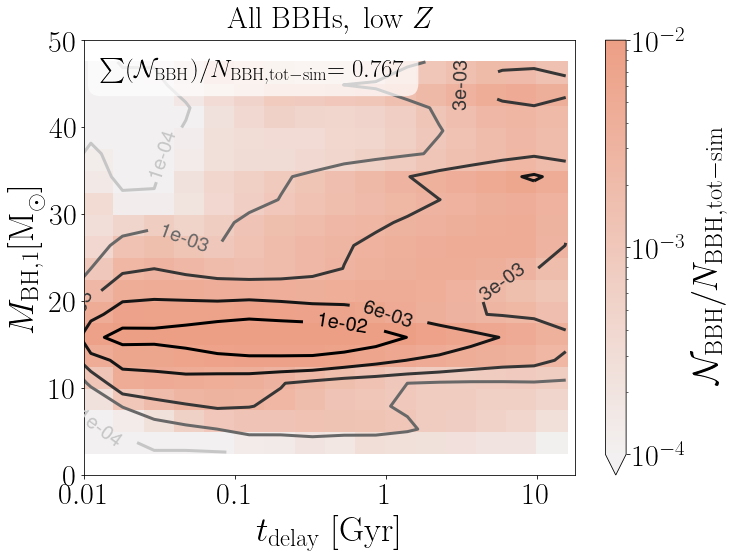

/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Log scale: values of z <= 0 have been masked


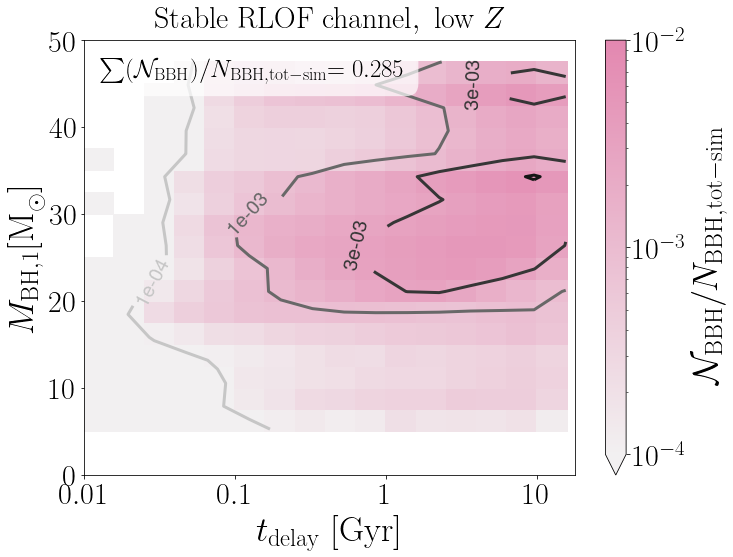

/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Log scale: values of z <= 0 have been masked


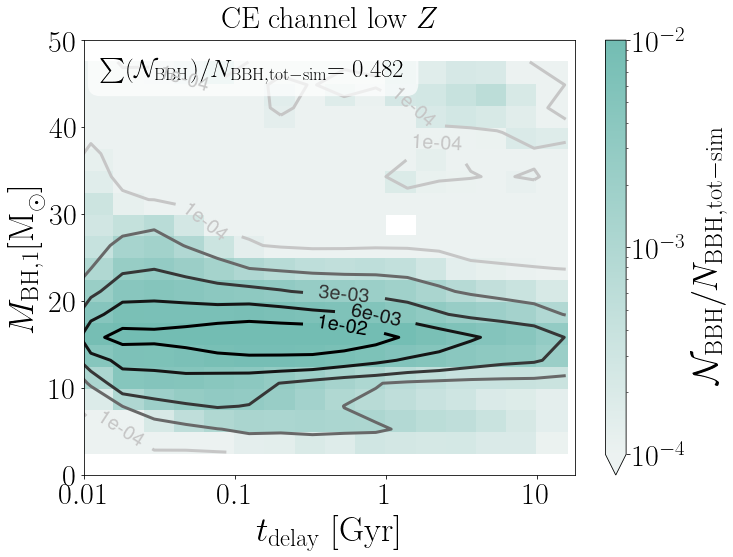

In [6]:
metal_border = 0.014/10.


#######################
# Low metallicity
low_Z_bool  = DCO['Metallicity@ZAMS(1)'] <= metal_border


## All BBH
Bool =  DCO_mask *nonCHE_bool * low_Z_bool
kleur_map = sns.light_palette("#ED9F85", as_cmap=True)
Tot_counts = plot_2dHist_MBH_tdelay(DCO, Bool, title='$\mathrm{All \ BBHs, \ low} \ Z$',  normalize = N_BBH_tot,
                                    Vmin = 1e-4, Vmax = 0.01,contour_levels = [1e-4, 1e-3, 3e-3,  6e-3, 1e-2],                                                                                                             
                                    savestr= sim_save_str+'All_lowZ', kleur = kleur_map, save_plot=True )



## No CE
noCEbool = DCO['CE_Event_Count'] == 0
Bool = noCEbool *DCO_mask * nonCHE_bool* low_Z_bool
kleur_map = sns.light_palette("#e388b0", as_cmap=True)#
Tot_counts = plot_2dHist_MBH_tdelay(DCO, Bool, title='$\mathrm{Stable \ RLOF \ channel, \ low} \ Z$',  normalize = N_BBH_tot,
                                    Vmin = 1e-4, Vmax = 0.01,contour_levels = [1e-4,1e-3, 3e-3,  6e-3, 1e-2],                                                                                                             
                                    savestr= sim_save_str+'RLOF_lowZ', kleur = kleur_map, save_plot=True )


## At least 1 CE
CEbool = DCO['CE_Event_Count'] > 0
Bool = CEbool *DCO_mask * nonCHE_bool* low_Z_bool
kleur_map = sns.light_palette("#73bdb3", as_cmap=True)#
Tot_counts = plot_2dHist_MBH_tdelay(DCO, Bool, title='$\mathrm{CE \ channel \ low} \ Z$',  normalize = N_BBH_tot,
                                    Vmin = 1e-4, Vmax = 0.01,contour_levels = [1e-4,1e-3, 3e-3,  6e-3, 1e-2],                                                                                                             
                                    savestr= sim_save_str+'CE_lowZ', kleur = kleur_map, save_plot=True )




# High metallicity
## $Z > \mathrm{Z_{\odot}}/5 $

/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Log scale: values of z <= 0 have been masked


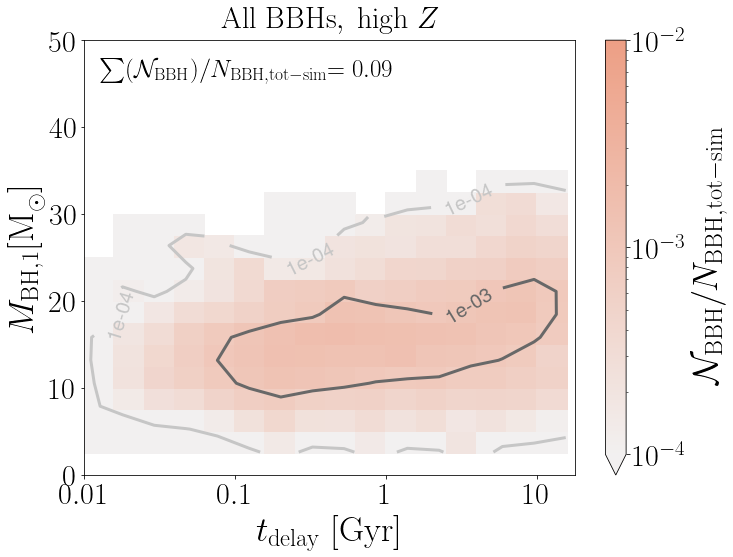

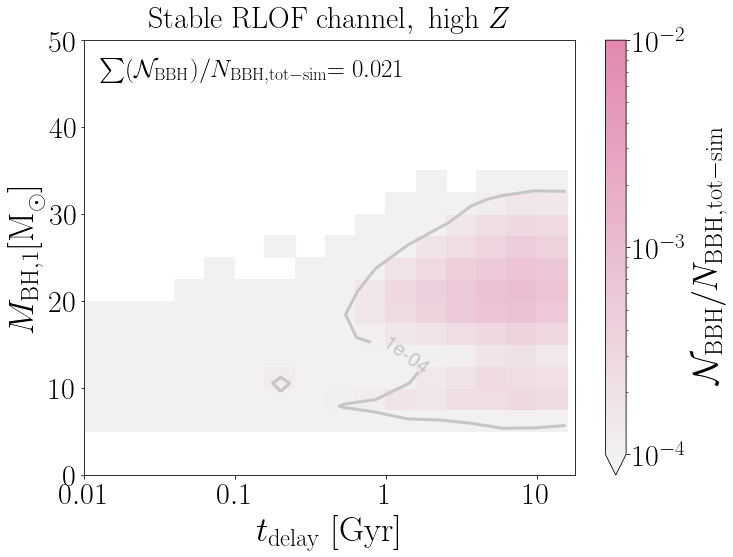

/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Log scale: values of z <= 0 have been masked


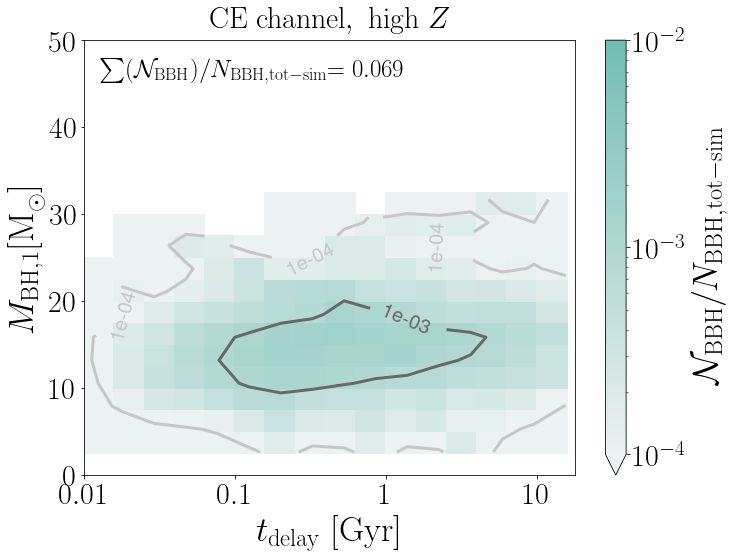

In [7]:
#######################
# High metallicity
high_Z_bool = DCO['Metallicity@ZAMS(1)'] > 0.014/5


## All BBH
Bool =  DCO_mask * nonCHE_bool* high_Z_bool
kleur_map = sns.light_palette("#ED9F85", as_cmap=True)
Tot_counts = plot_2dHist_MBH_tdelay(DCO, Bool, title='$\mathrm{All \ BBHs, \ high} \ Z$',  normalize = N_BBH_tot,
                                    Vmin = 1e-4, Vmax = 0.01,contour_levels = [1e-4, 1e-3, 3e-3,  6e-3, 1e-2],                                                                                                             
                                    savestr= sim_save_str+'All_highZ', kleur = kleur_map, save_plot=True )



## No CE
noCEbool = DCO['CE_Event_Count'] == 0
Bool = noCEbool * DCO_mask * nonCHE_bool* high_Z_bool
kleur_map = sns.light_palette("#e388b0", as_cmap=True)#
Tot_counts = plot_2dHist_MBH_tdelay(DCO, Bool, title='$\mathrm{Stable \ RLOF \ channel, \ high} \ Z$',  normalize = N_BBH_tot,
                                    Vmin = 1e-4, Vmax = 0.01,contour_levels = [1e-4, 1e-3, 3e-3,  6e-3, 1e-2],                                                                                                             
                                    savestr= sim_save_str+'RLOF_highZ', kleur = kleur_map, save_plot=True )



## At least 1 CE
CEbool = DCO['CE_Event_Count'] > 0
Bool = CEbool *DCO_mask * nonCHE_bool* high_Z_bool
kleur_map = sns.light_palette("#73bdb3", as_cmap=True)#
Tot_counts = plot_2dHist_MBH_tdelay(DCO, Bool, title='$\mathrm{CE \ channel, \ high} \ Z$',  normalize = N_BBH_tot,
                                    Vmin = 1e-4, Vmax = 0.01,contour_levels = [1e-4, 1e-3, 3e-3,  6e-3, 1e-2],                                                                                                             
                                    savestr= sim_save_str+'CE_highZ', kleur = kleur_map, save_plot=True )





*** 
***


# Extra: plotting the 2D histograms for all systems in our simulation
## i.e. not split by metallicity


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Log scale: values of z <= 0 have been masked


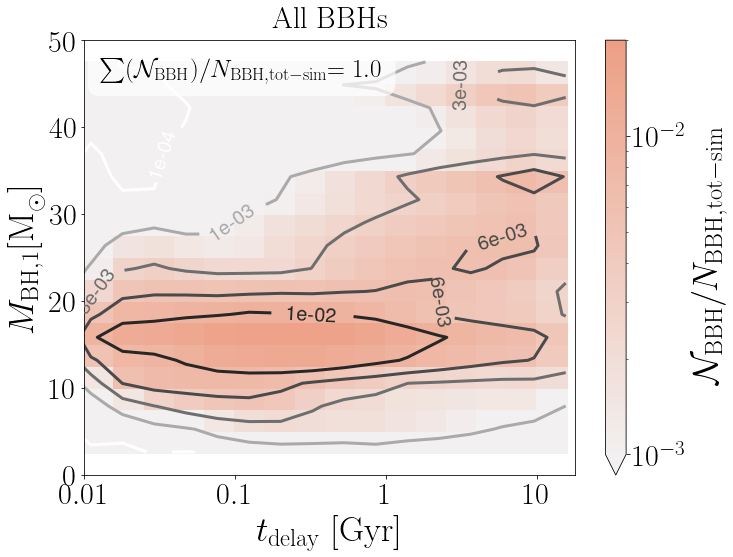

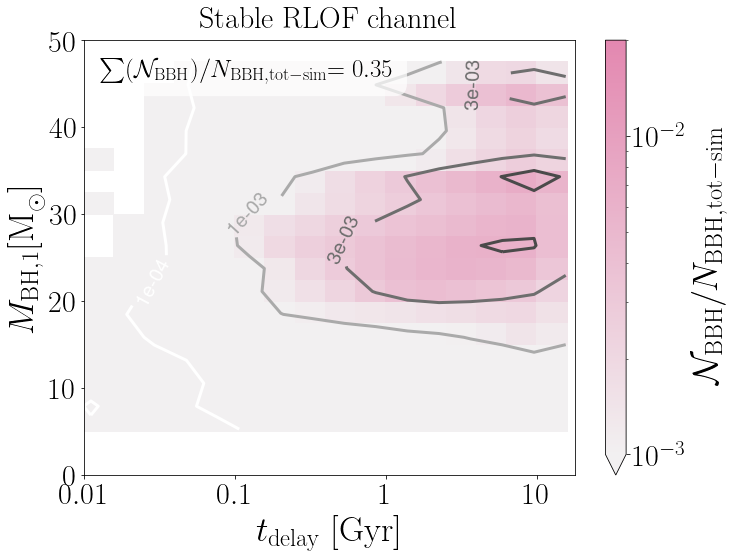

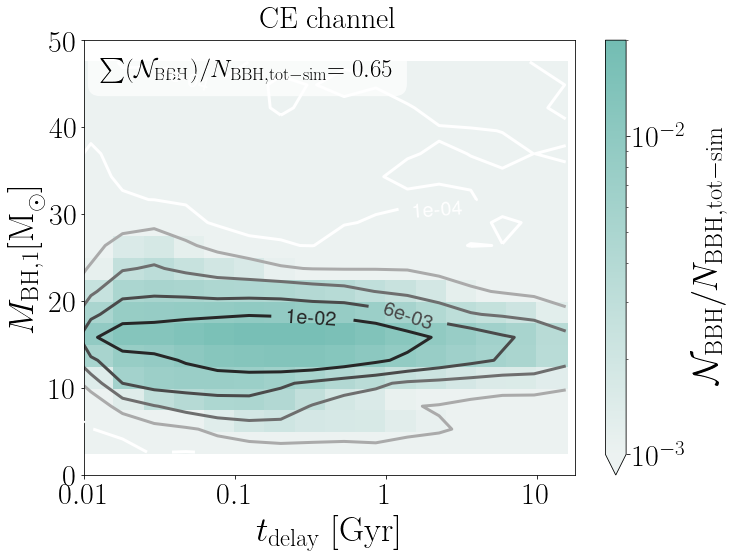

In [5]:
N_BBH_tot = np.sum(DCO['mixture_weight'][DCO_mask *nonCHE_bool])
save_loc    =  '../plots/extra_figures/'

## All BBH
Bool =  DCO_mask *nonCHE_bool
kleur_map = sns.light_palette("#ED9F85", as_cmap=True)
Tot_counts = plot_2dHist_MBH_tdelay(DCO, Bool, title='$\mathrm{All \ BBHs}$',  normalize = N_BBH_tot,
                                    Vmin = 1e-3, Vmax = 0.02,contour_levels = [1e-4, 1e-3, 3e-3,  6e-3, 1e-2],                                     
                                    savestr= sim_save_str+'All', kleur = kleur_map,save_plot=True )


## No CE
noCEbool = DCO['CE_Event_Count'] == 0
Bool = noCEbool *DCO_mask * nonCHE_bool
kleur_map = sns.light_palette("#e388b0", as_cmap=True)#
Tot_counts = plot_2dHist_MBH_tdelay(DCO, Bool, title='$\mathrm{Stable \ RLOF \ channel}$',  normalize = N_BBH_tot,
                                    Vmin = 1e-3, Vmax = 0.02,contour_levels = [1e-4,1e-3, 3e-3,  6e-3, 1e-2],                                                                         
                                    savestr= sim_save_str+'RLOF', kleur = kleur_map, save_plot=True )



## At least 1 CE
noCEbool = DCO['CE_Event_Count'] > 0
Bool = noCEbool *DCO_mask * nonCHE_bool
kleur_map = sns.light_palette("#73bdb3", as_cmap=True)#
Tot_counts = plot_2dHist_MBH_tdelay(DCO, Bool, title=' $\mathrm{CE \ channel}$',  normalize = N_BBH_tot,
                                    Vmin = 1e-3, Vmax = 0.02,contour_levels = [1e-4,1e-3, 3e-3,  6e-3, 1e-2],                                                                                                             
                                    savestr= sim_save_str+'CE', kleur = kleur_map, save_plot=True )

